RAW FILE ANALYSIS

✅ Loaded 101641 rows from /Users/paolabarrios/Desktop/Practicum/cpa_output.csv
DATA QUALITY DIAGNOSTICS
BASIC DATASET STATISTICS
Total rows: 101,641
Total columns: 33
Unique students: 463
Date range: 1/10/23 10:36 to 9/8/22 12:27
Empty student IDs: 0 rows

----------------------------------------
STUDENT EVALUATION DISTRIBUTION
Rows per student - Min: 20, Max: 822, Median: 113.0

EVALUATIONS PER STUDENT:
Students with evaluations: 463
Min evaluations: 1
Max evaluations: 42
Median evaluations: 5.0

Distribution:
  1 evaluations: 138 students
  2 evaluations: 17 students
  3 evaluations: 30 students
  4 evaluations: 24 students
  5 evaluations: 37 students
  6 evaluations: 34 students
  7 evaluations: 15 students
  8 evaluations: 6 students
  9 evaluations: 10 students
  10 evaluations: 1 students
  11 evaluations: 1 students
  12 evaluations: 1 students
  14 evaluations: 1 students
  15 evaluations: 3 students
  16 evaluations: 2 students
  17 evaluations: 2 students
  18 evaluations: 4

/var/folders/rk/qsjxfp614g394pt103myzt500000gn/T/ipykernel_54236/1853027131.py:326: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(rotation_eval_data, labels=rotation_names, patch_artist=True)


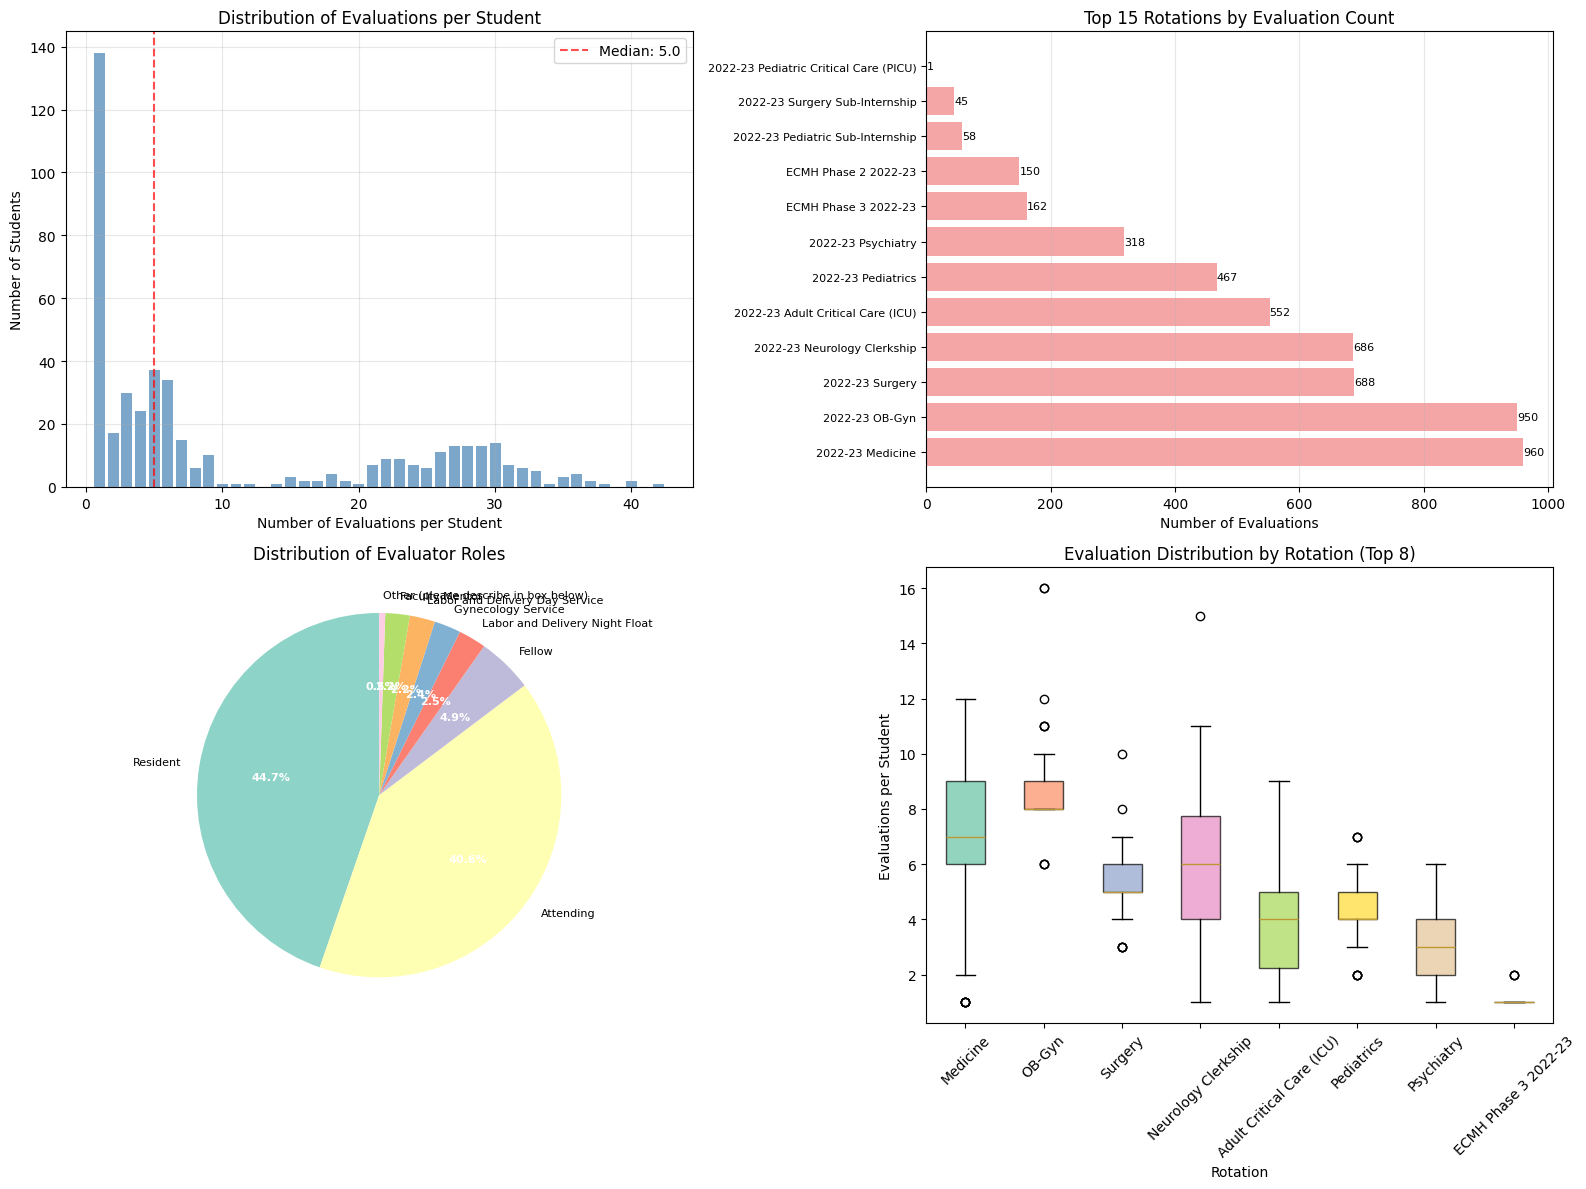


VISUALIZATION SUMMARY
Total rotations: 12
Most evaluated rotation: 2022-23 Medicine Clinical Performance Assessment (960 evaluations)
Most common evaluator role: Resident (2252 evaluations)


In [2]:
# data_processing/data_diagnostics.py
import pandas as pd
import os
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import re

class DataDiagnostics:
    """Diagnostic tool to analyze raw assessment data before cleaning"""
    
    def __init__(self, raw_data_path: str):
        """Initialize with path to raw data"""
        self.raw_data_path = raw_data_path
        self.df = None
        self.load_data()
    
    def load_data(self):
        """Load raw data"""
        try:
            self.df = pd.read_csv(self.raw_data_path, dtype=str)
            self.df = self.df.fillna('')
            print(f"✅ Loaded {len(self.df)} rows from {self.raw_data_path}")
        except Exception as e:
            raise Exception(f"Failed to load data: {e}")
    
    def run_full_diagnostics(self):
        """Run complete diagnostic suite"""
        print("="*60)
        print("DATA QUALITY DIAGNOSTICS")
        print("="*60)
        
        self.basic_stats()
        print("\n" + "-"*40)
        self.student_distribution_analysis()
        print("\n" + "-"*40)
        self.form_metadata_quality()
        print("\n" + "-"*40)
        self.evaluator_block_analysis()
        print("\n" + "-"*40)
        self.role_selection_analysis()
        print("\n" + "-"*40)
        self.identify_problem_students()
        print("\n" + "-"*40)
        self.data_loss_prediction()
        print("\n" + "-"*40)
        self.create_distribution_visualizations()
    
    def basic_stats(self):
        """Basic statistics about the dataset"""
        print("BASIC DATASET STATISTICS")
        print(f"Total rows: {len(self.df):,}")
        print(f"Total columns: {len(self.df.columns)}")
        print(f"Unique students: {self.df['student'].nunique()}")
        print(f"Date range: {self.df['releasedate'].min()} to {self.df['releasedate'].max()}")
        
        # Check for completely empty student IDs
        empty_students = self.df['student'].isna().sum() + (self.df['student'] == '').sum()
        print(f"Empty student IDs: {empty_students} rows")
    
    def student_distribution_analysis(self):
        """Analyze distribution of evaluations per student"""
        print("STUDENT EVALUATION DISTRIBUTION")
        
        # Count total rows per student
        student_row_counts = self.df['student'].value_counts()
        row_median = student_row_counts.median()
        print(f"Rows per student - Min: {student_row_counts.min()}, Max: {student_row_counts.max()}, Median: {row_median:.1f}")
        
        # Count evaluator blocks per student (role selection questions)
        role_questions = self.df[self.df['questionname'] == "Please select your role:"]
        evaluations_per_student = role_questions['student'].value_counts()
        
        print(f"\nEVALUATIONS PER STUDENT:")
        print(f"Students with evaluations: {len(evaluations_per_student)}")
        print(f"Min evaluations: {evaluations_per_student.min() if len(evaluations_per_student) > 0 else 0}")
        print(f"Max evaluations: {evaluations_per_student.max() if len(evaluations_per_student) > 0 else 0}")
        median_evals = evaluations_per_student.median() if len(evaluations_per_student) > 0 else 0
        print(f"Median evaluations: {median_evals:.1f}")
        
        # Distribution breakdown
        eval_dist = evaluations_per_student.value_counts().sort_index()
        print(f"\nDistribution:")
        for num_evals, student_count in eval_dist.items():
            print(f"  {num_evals} evaluations: {student_count} students")
        
        # Students with no role selection (potential problem)
        students_with_evals = set(evaluations_per_student.index)
        all_students = set(self.df['student'].unique())
        students_no_role = all_students - students_with_evals
        if students_no_role:
            print(f"\n⚠️  Students with NO role selection questions: {len(students_no_role)}")
            print(f"   Sample: {list(students_no_role)[:3]}")
    
    def form_metadata_quality(self):
        """Check quality of form metadata fields"""
        print("FORM METADATA QUALITY")
        
        metadata_fields = ['formname', 'phasename', 'academicyearname', 'releasedate']
        
        for field in metadata_fields:
            empty_count = (self.df[field] == '').sum() + self.df[field].isna().sum()
            unique_count = self.df[field].nunique()
            print(f"{field}: {empty_count:,} empty ({empty_count/len(self.df)*100:.1f}%), {unique_count} unique values")
        
        # Check form_key patterns that would be dropped
        form_keys = self.df.apply(
            lambda row: f"{row.get('formname', '')}|{row.get('phasename', '')}|{row.get('academicyearname', '')}|{row.get('releasedate', '')}", 
            axis=1
        )
        
        problematic_keys = form_keys[form_keys.str.contains(r'\|\|')]
        print(f"\n⚠️  Rows with problematic form_keys (would be dropped): {len(problematic_keys):,} ({len(problematic_keys)/len(self.df)*100:.1f}%)")
        
        if len(problematic_keys) > 0:
            # Show which students would be affected
            problematic_students = self.df[form_keys.str.contains(r'\|\|')]['student'].nunique()
            print(f"   Students affected: {problematic_students}")
    
    def evaluator_block_analysis(self):
        """Analyze evaluator block structure"""
        print("EVALUATOR BLOCK ANALYSIS")
        
        # Count role selection questions (block markers)
        role_questions = self.df[self.df['questionname'] == "Please select your role:"]
        print(f"Total evaluator blocks (role questions): {len(role_questions)}")
        
        # Analyze block sizes
        if len(role_questions) > 0:
            # Group by student and form to find blocks
            students_with_roles = role_questions.groupby('student').size()
            print(f"Students with role questions: {len(students_with_roles)}")
            
            # Check for role selection answers
            role_answers = role_questions['questionchoicetext'].value_counts()
            print(f"\nRole distribution:")
            for role, count in role_answers.items():
                if role:  # Non-empty roles
                    print(f"  {role}: {count}")
            
            empty_roles = (role_questions['questionchoicetext'] == '').sum()
            print(f"  Empty/missing roles: {empty_roles}")
    
    def role_selection_analysis(self):
        """Detailed analysis of role selection quality"""
        print("ROLE SELECTION QUALITY")
        
        role_questions = self.df[self.df['questionname'] == "Please select your role:"]
        
        if len(role_questions) == 0:
            print("⚠️  No role selection questions found!")
            return
        
        # Check for missing role answers
        missing_roles = role_questions['questionchoicetext'] == ''
        print(f"Evaluator blocks missing role selection: {missing_roles.sum()} ({missing_roles.sum()/len(role_questions)*100:.1f}%)")
        
        # Students who would lose evaluations due to missing roles
        students_missing_roles = role_questions[missing_roles]['student'].unique()
        if len(students_missing_roles) > 0:
            print(f"Students who would lose evaluations: {len(students_missing_roles)}")
            print(f"Sample students: {students_missing_roles[:5].tolist()}")
    
    def identify_problem_students(self):
        """Identify specific students who might lose data during cleaning"""
        print("PROBLEM STUDENT IDENTIFICATION")
        
        problem_students = set()
        
        # Students with problematic form keys
        form_keys = self.df.apply(
            lambda row: f"{row.get('formname', '')}|{row.get('phasename', '')}|{row.get('academicyearname', '')}|{row.get('releasedate', '')}", 
            axis=1
        )
        students_bad_keys = set(self.df[form_keys.str.contains(r'\|\|')]['student'].unique())
        problem_students.update(students_bad_keys)
        
        # Students with missing role selections
        role_questions = self.df[self.df['questionname'] == "Please select your role:"]
        if len(role_questions) > 0:
            missing_role_students = set(role_questions[role_questions['questionchoicetext'] == '']['student'].unique())
            problem_students.update(missing_role_students)
        
        print(f"Total students with potential data loss: {len(problem_students)}")
        
        if len(problem_students) > 0:
            print(f"Sample problem students: {list(problem_students)[:5]}")
            
            # Analyze one problem student in detail
            sample_student = list(problem_students)[0]
            self.analyze_student_detail(sample_student)
    
    def analyze_student_detail(self, student_id: str):
        """Detailed analysis of a specific student's data"""
        print(f"\nDETAILED ANALYSIS: Student {student_id}")
        
        student_data = self.df[self.df['student'] == student_id]
        print(f"Total rows: {len(student_data)}")
        
        # Check form metadata
        form_info = student_data[['formname', 'phasename', 'academicyearname', 'releasedate']].drop_duplicates()
        print(f"Unique form combinations: {len(form_info)}")
        
        for idx, row in form_info.iterrows():
            form_key = f"{row['formname']}|{row['phasename']}|{row['academicyearname']}|{row['releasedate']}"
            has_empty = '||' in form_key
            print(f"  Form: {form_key} {'❌ WOULD BE DROPPED' if has_empty else '✅'}")
        
        # Check role selections
        role_data = student_data[student_data['questionname'] == "Please select your role:"]
        print(f"Role selections: {len(role_data)}")
        for idx, row in role_data.iterrows():
            role = row['questionchoicetext']
            print(f"  Role: '{role}' {'❌ MISSING' if not role else '✅'}")
    
    def data_loss_prediction(self):
        """Predict how much data will be lost during cleaning"""
        print("DATA LOSS PREDICTION")
        
        original_students = self.df['student'].nunique()
        original_evaluations = len(self.df[self.df['questionname'] == "Please select your role:"])
        
        # Students that would be kept
        form_keys = self.df.apply(
            lambda row: f"{row.get('formname', '')}|{row.get('phasename', '')}|{row.get('academicyearname', '')}|{row.get('releasedate', '')}", 
            axis=1
        )
        
        # Data that would survive form key filtering
        surviving_form_data = self.df[~form_keys.str.contains(r'\|\|')]
        
        # Evaluations that would survive role filtering
        role_questions = surviving_form_data[surviving_form_data['questionname'] == "Please select your role:"]
        surviving_evaluations = role_questions[role_questions['questionchoicetext'] != '']
        
        final_students = surviving_evaluations['student'].nunique()
        final_evaluations = len(surviving_evaluations)
        
        print(f"PREDICTED RESULTS:")
        print(f"Students: {original_students} → {final_students} ({final_students/original_students*100:.1f}% retained)")
        print(f"Evaluations: {original_evaluations} → {final_evaluations} ({final_evaluations/original_evaluations*100:.1f}% retained)")
        print(f"Students lost: {original_students - final_students}")
        print(f"Evaluations lost: {original_evaluations - final_evaluations}")
    
    def create_distribution_visualizations(self):
        """Create visualizations for evaluation distribution and rotation analysis"""
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
            
            # Set style
            plt.style.use('default')
            sns.set_palette("husl")
            
            # Create figure with subplots
            fig = plt.figure(figsize=(16, 12))
            
            # 1. Evaluation Distribution Bar Chart
            ax1 = plt.subplot(2, 2, 1)
            role_questions = self.df[self.df['questionname'] == "Please select your role:"]
            evaluations_per_student = role_questions['student'].value_counts()
            eval_dist = evaluations_per_student.value_counts().sort_index()
            
            ax1.bar(eval_dist.index, eval_dist.values, alpha=0.7, color='steelblue')
            ax1.set_xlabel('Number of Evaluations per Student')
            ax1.set_ylabel('Number of Students')
            ax1.set_title('Distribution of Evaluations per Student')
            ax1.grid(True, alpha=0.3)
            
            # Add median line
            median_evals = evaluations_per_student.median()
            ax1.axvline(median_evals, color='red', linestyle='--', alpha=0.7, label=f'Median: {median_evals}')
            ax1.legend()
            
            # 2. Rotation Distribution
            ax2 = plt.subplot(2, 2, 2)
            rotation_dist = role_questions['formname'].value_counts()
            
            # Only show top 15 rotations for readability
            top_rotations = rotation_dist.head(15)
            
            bars = ax2.barh(range(len(top_rotations)), top_rotations.values, alpha=0.7, color='lightcoral')
            ax2.set_yticks(range(len(top_rotations)))
            ax2.set_yticklabels([name.replace(' Clinical Performance Assessment', '') for name in top_rotations.index], 
                               fontsize=8)
            ax2.set_xlabel('Number of Evaluations')
            ax2.set_title('Top 15 Rotations by Evaluation Count')
            ax2.grid(True, alpha=0.3, axis='x')
            
            # Add value labels on bars
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax2.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                        f'{int(width)}', ha='left', va='center', fontsize=8)
            
            # 3. Evaluator Role Distribution
            ax3 = plt.subplot(2, 2, 3)
            role_dist = role_questions['questionchoicetext'].value_counts()
            
            # Create pie chart for roles
            colors = plt.cm.Set3(range(len(role_dist)))
            wedges, texts, autotexts = ax3.pie(role_dist.values, labels=role_dist.index, autopct='%1.1f%%', 
                                              colors=colors, startangle=90)
            ax3.set_title('Distribution of Evaluator Roles')
            
            # Make text smaller for readability
            for text in texts:
                text.set_fontsize(8)
            for autotext in autotexts:
                autotext.set_fontsize(8)
                autotext.set_color('white')
                autotext.set_weight('bold')
            
            # 4. Evaluation Distribution by Rotation (Box plot for top rotations)
            ax4 = plt.subplot(2, 2, 4)
            
            # Get evaluations per student for each rotation
            rotation_eval_data = []
            rotation_names = []
            
            for rotation in top_rotations.head(8).index:  # Top 8 for readability
                rotation_students = role_questions[role_questions['formname'] == rotation]['student']
                student_eval_counts = rotation_students.value_counts()
                rotation_eval_data.append(student_eval_counts.values)
                rotation_names.append(rotation.replace(' Clinical Performance Assessment', '').replace('2022-23 ', ''))
            
            bp = ax4.boxplot(rotation_eval_data, labels=rotation_names, patch_artist=True)
            ax4.set_xlabel('Rotation')
            ax4.set_ylabel('Evaluations per Student')
            ax4.set_title('Evaluation Distribution by Rotation (Top 8)')
            ax4.tick_params(axis='x', rotation=45)
            
            # Color the boxes
            colors = plt.cm.Set2(range(len(bp['boxes'])))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print("\n" + "="*60)
            print("VISUALIZATION SUMMARY")
            print("="*60)
            print(f"Total rotations: {rotation_dist.nunique()}")
            print(f"Most evaluated rotation: {rotation_dist.index[0]} ({rotation_dist.iloc[0]} evaluations)")
            print(f"Most common evaluator role: {role_dist.index[0]} ({role_dist.iloc[0]} evaluations)")
            
        except ImportError:
            print("⚠️  Matplotlib/Seaborn not available. Install with: pip install matplotlib seaborn")
            print("\nTEXT-BASED VISUALIZATION:")
            self._create_text_visualizations()
    
    def _create_text_visualizations(self):
        """Create text-based visualizations if matplotlib not available"""
        print("\nEVALUATION DISTRIBUTION (Text Chart):")
        role_questions = self.df[self.df['questionname'] == "Please select your role:"]
        evaluations_per_student = role_questions['student'].value_counts()
        eval_dist = evaluations_per_student.value_counts().sort_index()
        
        max_count = eval_dist.max()
        for num_evals, student_count in eval_dist.items():
            bar_length = int((student_count / max_count) * 50)
            bar = "█" * bar_length
            print(f"{num_evals:2d} evals: {student_count:3d} students {bar}")
        
        print(f"\nROTATION DISTRIBUTION:")
        rotation_dist = role_questions['formname'].value_counts().head(10)
        max_count = rotation_dist.max()
        
        for rotation, count in rotation_dist.items():
            bar_length = int((count / max_count) * 30)
            bar = "█" * bar_length
            short_name = rotation.replace(' Clinical Performance Assessment', '').replace('2022-23 ', '')
            print(f"{short_name[:30]:30s} {count:4d} {bar}")

def main():
    """Run diagnostics from command line"""
    raw_data_path = "/Users/paolabarrios/Desktop/Practicum/cpa_output.csv"
    
    if not os.path.exists(raw_data_path):
        print(f"File not found: {raw_data_path}")
        return
    
    diagnostics = DataDiagnostics(raw_data_path)
    diagnostics.run_full_diagnostics()

if __name__ == "__main__":
    main()

CLEAN FILE ANALYSIS

✅ Loaded 5037 rows from /Users/paolabarrios/AI_MED/CPA_AGENTS/cpa_data/cpa_clean.csv
CLEANED DATA ANALYSIS
BASIC CLEANED DATASET STATISTICS
Total evaluations: 5,037
Total columns: 29
Unique students: 463
Date range: 2022-07-05 to 2024-05-14
Missing student IDs: 0 rows

----------------------------------------
STUDENT EVALUATION DISTRIBUTION
EVALUATIONS PER STUDENT:
Students with evaluations: 463
Min evaluations: 1
Max evaluations: 42
Median evaluations: 5.0
Mean evaluations: 10.9

Distribution:
  1 evaluations: 138 students
  2 evaluations: 17 students
  3 evaluations: 30 students
  4 evaluations: 24 students
  5 evaluations: 37 students
  6 evaluations: 34 students
  7 evaluations: 15 students
  8 evaluations: 6 students
  9 evaluations: 10 students
  10 evaluations: 1 students
  11 evaluations: 1 students
  12 evaluations: 1 students
  14 evaluations: 1 students
  15 evaluations: 3 students
  16 evaluations: 2 students
  17 evaluations: 2 students
  18 evaluations: 4 students
  19 ev

/var/folders/rk/qsjxfp614g394pt103myzt500000gn/T/ipykernel_54236/2963875073.py:393: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(rotation_eval_data, labels=rotation_names, patch_artist=True)


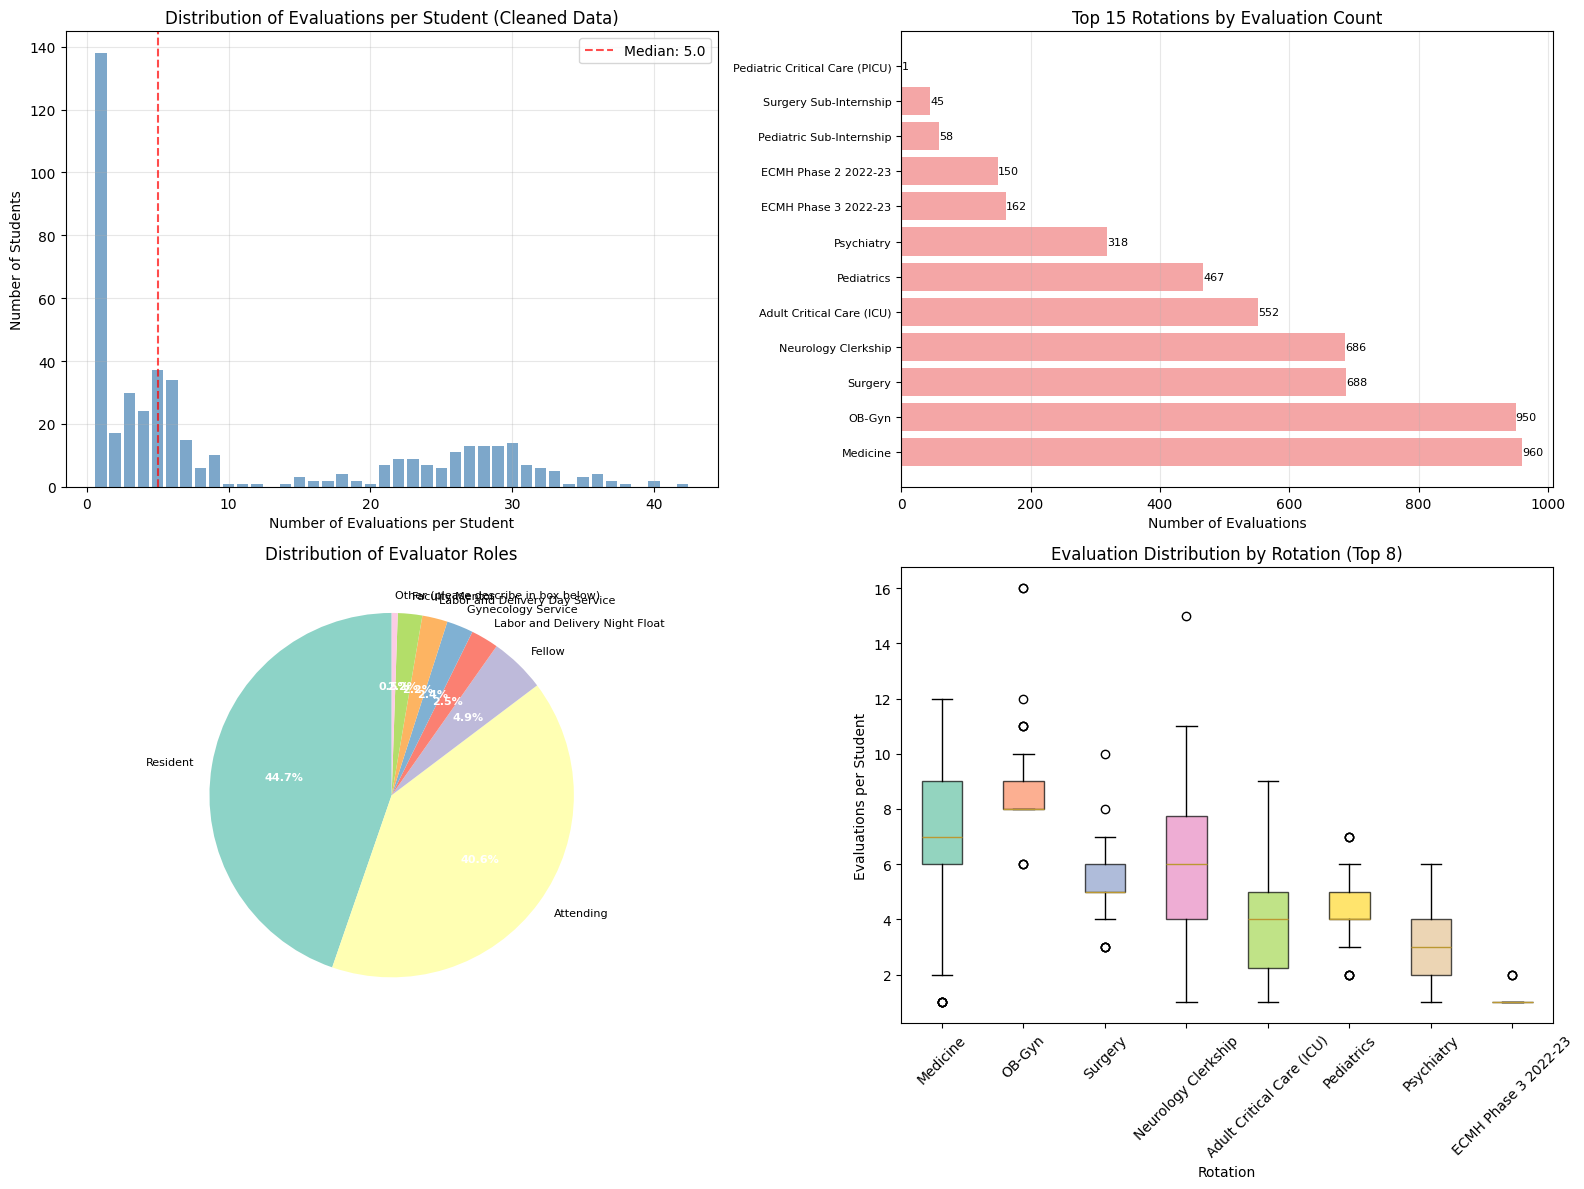


CLEANED DATA VISUALIZATION SUMMARY
Total rotations: 12
Most evaluated rotation: 2022-23 Medicine Clinical Performance Assessment (960 evaluations)
Most common evaluator role: Resident (2252 evaluations)
Total students analyzed: 463
Total evaluations analyzed: 5037


In [9]:
# data_processing/cleaned_data_analyzer.py
import pandas as pd
import os
from typing import Dict, List, Tuple

class CleanedDataAnalyzer:
    """Analyzer for cleaned assessment data"""
    
    def __init__(self, cleaned_data_path: str):
        """Initialize with path to cleaned data"""
        self.cleaned_data_path = cleaned_data_path
        self.df = None
        self.load_data()
    
    def load_data(self):
        """Load cleaned data"""
        try:
            self.df = pd.read_csv(self.cleaned_data_path)
            print(f"✅ Loaded {len(self.df)} rows from {self.cleaned_data_path}")
        except Exception as e:
            raise Exception(f"Failed to load data: {e}")
    
    def run_full_analysis(self):
        """Run complete analysis suite"""
        print("="*60)
        print("CLEANED DATA ANALYSIS")
        print("="*60)
        
        self.basic_stats()
        print("\n" + "-"*40)
        self.student_distribution_analysis()
        print("\n" + "-"*40)
        self.rotation_analysis()
        print("\n" + "-"*40)
        self.evaluator_role_analysis()
        print("\n" + "-"*40)
        self.cross_rotation_diversity_analysis()
        print("\n" + "-"*40)
        self.system_readiness_analysis()
        print("\n" + "-"*40)
        self.create_distribution_visualizations()
    
    def basic_stats(self):
        """Basic statistics about the cleaned dataset"""
        print("BASIC CLEANED DATASET STATISTICS")
        print(f"Total evaluations: {len(self.df):,}")
        print(f"Total columns: {len(self.df.columns)}")
        print(f"Unique students: {self.df['student_id'].nunique()}")
        
        # Date range
        if 'release_date' in self.df.columns:
            print(f"Date range: {self.df['release_date'].min()} to {self.df['release_date'].max()}")
        
        # Check for missing student IDs
        empty_students = self.df['student_id'].isna().sum()
        print(f"Missing student IDs: {empty_students} rows")
    
    def student_distribution_analysis(self):
        """Analyze distribution of evaluations per student"""
        print("STUDENT EVALUATION DISTRIBUTION")
        
        # Count evaluations per student
        evaluations_per_student = self.df['student_id'].value_counts()
        
        print(f"EVALUATIONS PER STUDENT:")
        print(f"Students with evaluations: {len(evaluations_per_student)}")
        print(f"Min evaluations: {evaluations_per_student.min()}")
        print(f"Max evaluations: {evaluations_per_student.max()}")
        print(f"Median evaluations: {evaluations_per_student.median():.1f}")
        print(f"Mean evaluations: {evaluations_per_student.mean():.1f}")
        
        # Distribution breakdown
        eval_dist = evaluations_per_student.value_counts().sort_index()
        print(f"\nDistribution:")
        for num_evals, student_count in eval_dist.items():
            print(f"  {num_evals} evaluations: {student_count} students")
        
        # Students with very few evaluations
        few_evals = evaluations_per_student[evaluations_per_student <= 2]
        if len(few_evals) > 0:
            print(f"\n⚠️  Students with ≤2 evaluations: {len(few_evals)} ({len(few_evals)/len(evaluations_per_student)*100:.1f}%)")
    
    def rotation_analysis(self):
        """Analyze evaluations by rotation/form"""
        print("ROTATION ANALYSIS")
        
        if 'form_name' in self.df.columns:
            rotation_dist = self.df['form_name'].value_counts()
            print(f"Total rotations: {len(rotation_dist)}")
            print(f"Most evaluated rotation: {rotation_dist.index[0]} ({rotation_dist.iloc[0]} evaluations)")
            
            print(f"\nTop 10 rotations by evaluation count:")
            for rotation, count in rotation_dist.head(10).items():
                short_name = rotation.replace(' Clinical Performance Assessment', '').replace('2022-23 ', '')
                print(f"  {short_name}: {count} evaluations")
                
            # Students per rotation
            print(f"\nStudents per rotation (top 10):")
            rotation_students = self.df.groupby('form_name')['student_id'].nunique().sort_values(ascending=False)
            for rotation, student_count in rotation_students.head(10).items():
                short_name = rotation.replace(' Clinical Performance Assessment', '').replace('2022-23 ', '')
                avg_evals = rotation_dist[rotation] / student_count
                print(f"  {short_name}: {student_count} students ({avg_evals:.1f} evals/student)")
        else:
            print("No form_name column found in cleaned data")
    
    def evaluator_role_analysis(self):
        """Analyze evaluations by evaluator role"""
        print("EVALUATOR ROLE ANALYSIS")
        
        if 'evaluator_role' in self.df.columns:
            role_dist = self.df['evaluator_role'].value_counts()
            print(f"Evaluator roles found: {len(role_dist)}")
            print(f"Most common role: {role_dist.index[0]} ({role_dist.iloc[0]} evaluations)")
            
            print(f"\nRole distribution:")
            total_evals = len(self.df)
            for role, count in role_dist.items():
                print(f"  {role}: {count} evaluations ({count/total_evals*100:.1f}%)")
        else:
            print("No evaluator_role column found in cleaned data")
    
    def cross_rotation_diversity_analysis(self):
        """Analyze cross-rotation diversity for each student"""
        print("CROSS-ROTATION DIVERSITY ANALYSIS")
        
        if 'form_name' not in self.df.columns:
            print("No form_name column found - cannot analyze rotation diversity")
            return
        
        # Group by student and analyze their rotation portfolio
        student_rotation_data = []
        
        for student_id in self.df['student_id'].unique():
            student_data = self.df[self.df['student_id'] == student_id]
            
            # Count evaluations per rotation for this student
            rotation_counts = student_data['form_name'].value_counts()
            
            student_rotation_data.append({
                'student_id': student_id,
                'total_evaluations': len(student_data),
                'unique_rotations': len(rotation_counts),
                'rotation_counts': rotation_counts.to_dict(),
                'avg_evals_per_rotation': len(student_data) / len(rotation_counts) if len(rotation_counts) > 0 else 0
            })
        
        # Convert to DataFrame for analysis
        rotation_df = pd.DataFrame(student_rotation_data)
        
        print(f"ROTATION DIVERSITY STATISTICS:")
        print(f"Students analyzed: {len(rotation_df)}")
        print(f"Rotations per student - Min: {rotation_df['unique_rotations'].min()}, Max: {rotation_df['unique_rotations'].max()}, Median: {rotation_df['unique_rotations'].median():.1f}")
        print(f"Average evals per rotation - Min: {rotation_df['avg_evals_per_rotation'].min():.1f}, Max: {rotation_df['avg_evals_per_rotation'].max():.1f}, Median: {rotation_df['avg_evals_per_rotation'].median():.1f}")
        
        # Distribution of unique rotations per student
        rotation_dist = rotation_df['unique_rotations'].value_counts().sort_index()
        print(f"\nROTATIONS PER STUDENT DISTRIBUTION:")
        for num_rotations, student_count in rotation_dist.items():
            print(f"  {num_rotations} rotation{'s' if num_rotations != 1 else ''}: {student_count} students ({student_count/len(rotation_df)*100:.1f}%)")
        
        # Students with multiple rotations
        multi_rotation_students = rotation_df[rotation_df['unique_rotations'] >= 2]
        print(f"\nStudents with 2+ rotations: {len(multi_rotation_students)} ({len(multi_rotation_students)/len(rotation_df)*100:.1f}%)")
        
        if len(multi_rotation_students) > 0:
            print(f"Among multi-rotation students:")
            print(f"  Average rotations: {multi_rotation_students['unique_rotations'].mean():.1f}")
            print(f"  Average total evaluations: {multi_rotation_students['total_evaluations'].mean():.1f}")
            print(f"  Average evals per rotation: {multi_rotation_students['avg_evals_per_rotation'].mean():.1f}")
        
        # Analyze evaluation distribution within rotations
        print(f"\nEVALUATIONS PER ROTATION PATTERNS:")
        
        # Collect all rotation eval counts across all students
        all_rotation_eval_counts = []
        for _, student in rotation_df.iterrows():
            all_rotation_eval_counts.extend(student['rotation_counts'].values())
        
        if all_rotation_eval_counts:
            rotation_eval_series = pd.Series(all_rotation_eval_counts)
            eval_per_rotation_dist = rotation_eval_series.value_counts().sort_index()
            
            print(f"Distribution of evaluations per rotation instance:")
            for num_evals, count in eval_per_rotation_dist.items():
                print(f"  {num_evals} eval{'s' if num_evals != 1 else ''} per rotation: {count} instances ({count/len(all_rotation_eval_counts)*100:.1f}%)")
        
        # Store for system readiness analysis
        self.rotation_analysis_data = rotation_df
    
    def system_readiness_analysis(self):
        """Analyze how many students meet different readiness thresholds"""
        print("SYSTEM READINESS ANALYSIS")
        
        if not hasattr(self, 'rotation_analysis_data'):
            print("Cross-rotation analysis must be run first")
            return
        
        df = self.rotation_analysis_data
        
        print("READINESS THRESHOLDS:")
        
        # Simple total evaluation thresholds
        thresholds = [1, 2, 3, 4, 5, 7, 10]
        for threshold in thresholds:
            ready_students = df[df['total_evaluations'] >= threshold]
            print(f"  {threshold}+ total evaluations: {len(ready_students)} students ({len(ready_students)/len(df)*100:.1f}%)")
        
        print(f"\nCROSS-ROTATION READINESS (Proposed Thresholds):")
        
        # Cross-rotation sophisticated thresholds
        criteria = [
            ("1+ rotations, 4+ total evals", 1, 4),
            ("2+ rotations, 4+ total evals", 2, 4),
            ("2+ rotations, 6+ total evals", 2, 6), 
            ("3+ rotations, 6+ total evals", 3, 6),
            ("3+ rotations, 9+ total evals", 3, 9)
        ]
        
        for description, min_rotations, min_total_evals in criteria:
            ready_students = df[
                (df['unique_rotations'] >= min_rotations) & 
                (df['total_evaluations'] >= min_total_evals)
            ]
            print(f"  {description}: {len(ready_students)} students ({len(ready_students)/len(df)*100:.1f}%)")
        
        # Recommended threshold analysis
        print(f"\nRECOMMENDED THRESHOLD: 3+ rotations, 6+ total evaluations, 2+ evals per rotation")
        print(f"  (Ensures cross-specialty diversity and within-rotation reliability)")
        
        # Apply the sophisticated threshold
        recommended_ready = []
        for _, student in df.iterrows():
            meets_criteria = (
                student['unique_rotations'] >= 3 and 
                student['total_evaluations'] >= 6 and
                all(count >= 2 for count in student['rotation_counts'].values())
            )
            if meets_criteria:
                recommended_ready.append(student)
        
        recommended_ready_df = pd.DataFrame(recommended_ready) if recommended_ready else pd.DataFrame()
        
        if len(recommended_ready_df) > 0:
            print(f"  Ready students: {len(recommended_ready_df)} ({len(recommended_ready_df)/len(df)*100:.1f}%)")
            print(f"  Average rotations: {recommended_ready_df['unique_rotations'].mean():.1f}")
            print(f"  Average total evals: {recommended_ready_df['total_evaluations'].mean():.1f}")
            print(f"  Average evals per rotation: {recommended_ready_df['avg_evals_per_rotation'].mean():.1f}")
        else:
            print(f"  Ready students: 0 (0.0%)")
        
        # Students close to threshold
        print(f"\nSTUDENTS CLOSE TO READINESS:")
        
        # Students with 3+ rotations, 6+ evals, but some rotations have only 1 eval
        good_diversity_need_depth = []
        for _, student in df.iterrows():
            if (student['unique_rotations'] >= 3 and 
                student['total_evaluations'] >= 6 and
                any(count == 1 for count in student['rotation_counts'].values())):
                good_diversity_need_depth.append(student)
        
        print(f"  3+ rotations, 6+ evals, but some rotations have only 1 eval: {len(good_diversity_need_depth)} students")
        print(f"    (Need a few more evaluations in existing rotations)")
        
        # Students with 2 rotations but lots of evals
        good_depth_need_diversity = df[
            (df['unique_rotations'] == 2) & 
            (df['total_evaluations'] >= 6)
        ]
        print(f"  2 rotations, 6+ evals: {len(good_depth_need_diversity)} students")
        print(f"    (Need 1 more rotation type)")
        
        # Students with 3+ rotations but <6 total evals
        good_diversity_need_more = df[
            (df['unique_rotations'] >= 3) & 
            (df['total_evaluations'] < 6)
        ]
        print(f"  3+ rotations, <6 total evals: {len(good_diversity_need_more)} students")
        print(f"    (Need more evaluations overall)")
        
        # Show examples of student portfolios
        print(f"\nSAMPLE STUDENT PORTFOLIOS:")
        
        if len(recommended_ready_df) > 0:
            sample_ready = recommended_ready_df.iloc[0]
            print(f"  Ready student example:")
            print(f"    Total evals: {int(sample_ready['total_evaluations'])}, Rotations: {int(sample_ready['unique_rotations'])}")
            for rotation, count in list(sample_ready['rotation_counts'].items())[:3]:
                short_name = rotation.replace(' Clinical Performance Assessment', '').replace('2022-23 ', '')
                print(f"    {short_name}: {count} evaluations")
        
        if len(good_depth_need_diversity) > 0:
            sample_need_diversity = good_depth_need_diversity.iloc[0]
            print(f"  High-depth, needs diversity example:")
            print(f"    Total evals: {int(sample_need_diversity['total_evaluations'])}, Rotations: {int(sample_need_diversity['unique_rotations'])}")
            for rotation, count in list(sample_need_diversity['rotation_counts'].items())[:3]:
                short_name = rotation.replace(' Clinical Performance Assessment', '').replace('2022-23 ', '')
                print(f"    {short_name}: {count} evaluations")
    
    def create_distribution_visualizations(self):
        """Create visualizations for cleaned data analysis"""
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
            
            # Set style
            plt.style.use('default')
            sns.set_palette("husl")
            
            # Create figure with subplots
            fig = plt.figure(figsize=(16, 12))
            
            # 1. Evaluation Distribution Bar Chart
            ax1 = plt.subplot(2, 2, 1)
            evaluations_per_student = self.df['student_id'].value_counts()
            eval_dist = evaluations_per_student.value_counts().sort_index()
            
            ax1.bar(eval_dist.index, eval_dist.values, alpha=0.7, color='steelblue')
            ax1.set_xlabel('Number of Evaluations per Student')
            ax1.set_ylabel('Number of Students')
            ax1.set_title('Distribution of Evaluations per Student (Cleaned Data)')
            ax1.grid(True, alpha=0.3)
            
            # Add median line
            median_evals = evaluations_per_student.median()
            ax1.axvline(median_evals, color='red', linestyle='--', alpha=0.7, label=f'Median: {median_evals}')
            ax1.legend()
            
            # 2. Rotation Distribution (if available)
            ax2 = plt.subplot(2, 2, 2)
            if 'form_name' in self.df.columns:
                rotation_dist = self.df['form_name'].value_counts()
                top_rotations = rotation_dist.head(15)
                
                bars = ax2.barh(range(len(top_rotations)), top_rotations.values, alpha=0.7, color='lightcoral')
                ax2.set_yticks(range(len(top_rotations)))
                ax2.set_yticklabels([name.replace(' Clinical Performance Assessment', '').replace('2022-23 ', '') 
                                   for name in top_rotations.index], fontsize=8)
                ax2.set_xlabel('Number of Evaluations')
                ax2.set_title('Top 15 Rotations by Evaluation Count')
                ax2.grid(True, alpha=0.3, axis='x')
                
                # Add value labels on bars
                for i, bar in enumerate(bars):
                    width = bar.get_width()
                    ax2.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                            f'{int(width)}', ha='left', va='center', fontsize=8)
            else:
                ax2.text(0.5, 0.5, 'No form_name data available', 
                        ha='center', va='center', transform=ax2.transAxes)
                ax2.set_title('Rotation Distribution - No Data')
            
            # 3. Evaluator Role Distribution (if available)
            ax3 = plt.subplot(2, 2, 3)
            if 'evaluator_role' in self.df.columns:
                role_dist = self.df['evaluator_role'].value_counts()
                
                # Create pie chart for roles
                colors = plt.cm.Set3(range(len(role_dist)))
                wedges, texts, autotexts = ax3.pie(role_dist.values, labels=role_dist.index, autopct='%1.1f%%', 
                                                  colors=colors, startangle=90)
                ax3.set_title('Distribution of Evaluator Roles')
                
                # Make text smaller for readability
                for text in texts:
                    text.set_fontsize(8)
                for autotext in autotexts:
                    autotext.set_fontsize(8)
                    autotext.set_color('white')
                    autotext.set_weight('bold')
            else:
                ax3.text(0.5, 0.5, 'No evaluator_role data available', 
                        ha='center', va='center', transform=ax3.transAxes)
                ax3.set_title('Evaluator Role Distribution - No Data')
            
            # 4. Evaluation Distribution by Rotation (Box plot)
            ax4 = plt.subplot(2, 2, 4)
            if 'form_name' in self.df.columns:
                rotation_dist = self.df['form_name'].value_counts()
                top_rotations = rotation_dist.head(8)
                
                # Get evaluations per student for each rotation
                rotation_eval_data = []
                rotation_names = []
                
                for rotation in top_rotations.index:
                    rotation_students = self.df[self.df['form_name'] == rotation]['student_id']
                    student_eval_counts = rotation_students.value_counts()
                    rotation_eval_data.append(student_eval_counts.values)
                    rotation_names.append(rotation.replace(' Clinical Performance Assessment', '').replace('2022-23 ', ''))
                
                bp = ax4.boxplot(rotation_eval_data, labels=rotation_names, patch_artist=True)
                ax4.set_xlabel('Rotation')
                ax4.set_ylabel('Evaluations per Student')
                ax4.set_title('Evaluation Distribution by Rotation (Top 8)')
                ax4.tick_params(axis='x', rotation=45)
                
                # Color the boxes
                colors = plt.cm.Set2(range(len(bp['boxes'])))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
            else:
                ax4.text(0.5, 0.5, 'No form_name data available', 
                        ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Rotation Analysis - No Data')
            
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print("\n" + "="*60)
            print("CLEANED DATA VISUALIZATION SUMMARY")
            print("="*60)
            
            if 'form_name' in self.df.columns:
                rotation_dist = self.df['form_name'].value_counts()
                print(f"Total rotations: {len(rotation_dist)}")
                print(f"Most evaluated rotation: {rotation_dist.index[0]} ({rotation_dist.iloc[0]} evaluations)")
            
            if 'evaluator_role' in self.df.columns:
                role_dist = self.df['evaluator_role'].value_counts()
                print(f"Most common evaluator role: {role_dist.index[0]} ({role_dist.iloc[0]} evaluations)")
            
            print(f"Total students analyzed: {self.df['student_id'].nunique()}")
            print(f"Total evaluations analyzed: {len(self.df)}")
            
        except ImportError:
            print("⚠️  Matplotlib/Seaborn not available. Install with: pip install matplotlib seaborn")
            print("\nTEXT-BASED VISUALIZATION:")
            self._create_text_visualizations()
    
    def _create_text_visualizations(self):
        """Create text-based visualizations if matplotlib not available"""
        print("\nEVALUATION DISTRIBUTION (Text Chart):")
        evaluations_per_student = self.df['student_id'].value_counts()
        eval_dist = evaluations_per_student.value_counts().sort_index()
        
        max_count = eval_dist.max()
        for num_evals, student_count in eval_dist.items():
            bar_length = int((student_count / max_count) * 50)
            bar = "█" * bar_length
            print(f"{num_evals:2d} evals: {student_count:3d} students {bar}")
        
        if 'form_name' in self.df.columns:
            print(f"\nROTATION DISTRIBUTION:")
            rotation_dist = self.df['form_name'].value_counts().head(10)
            max_count = rotation_dist.max()
            
            for rotation, count in rotation_dist.items():
                bar_length = int((count / max_count) * 30)
                bar = "█" * bar_length
                short_name = rotation.replace(' Clinical Performance Assessment', '').replace('2022-23 ', '')
                print(f"{short_name[:30]:30s} {count:4d} {bar}")

def main():
    """Run analysis from command line"""
    cleaned_data_path = "/Users/paolabarrios/AI_MED/CPA_AGENTS/cpa_data/cpa_clean.csv"
    
    if not os.path.exists(cleaned_data_path):
        print(f"File not found: {cleaned_data_path}")
        return
    
    analyzer = CleanedDataAnalyzer(cleaned_data_path)
    analyzer.run_full_analysis()

if __name__ == "__main__":
    main()